# Import and Download

In [1]:
!pip install sklearn gensim plotly

In [2]:
# Load libraries
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from copy import deepcopy
from sklearn.decomposition import TruncatedSVD
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from scipy import sparse
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
import gensim
import gc
import plotly
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
from os import path
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
import seaborn as sns
from collections import defaultdict
import math
%matplotlib inline

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# SVM 
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier 
from sklearn.model_selection import GridSearchCV  
from sklearn.metrics import roc_curve, auc



# LDA
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay

# ROC AUC Curves
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# PR Curves
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import PrecisionRecallDisplay

# Confusion Matrix
from sklearn import metrics

import multiprocessing
from joblib import Parallel, delayed

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
num_cores = multiprocessing.cpu_count()
print('Total number of cores: {}'.format(num_cores))

Total number of cores: 6


# Data Glimpse

train shape: (1306122, 3)
test shape: (375806, 2)
No. of sincere questions 1225312 Percentage: 93 %
No. of Insincere questions 80810 Percentage: 7 %


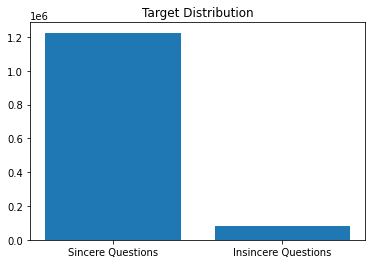

TRAIN HEAD IS


qid                                      question_text  \
0  00002165364db923c7e6  How did Quebec nationalists see their province...   
1  000032939017120e6e44  Do you have an adopted dog, how would you enco...   
2  0000412ca6e4628ce2cf  Why does velocity affect time? Does velocity a...   
3  000042bf85aa498cd78e  How did Otto von Guericke used the Magdeburg h...   
4  0000455dfa3e01eae3af  Can I convert montra helicon D to a mountain b...   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

In [4]:
print("train shape: "+str(train.shape))
print("test shape: "+str(test.shape))

sincere_ques=train[train['target']==0]
insincere_ques=train[train['target']==1]
num_of_sinc=sincere_ques.shape[0]
num_of_insinc=insincere_ques.shape[0]
percentage_of_sincere=((num_of_sinc)/(num_of_sinc+num_of_insinc))*100
percentage_of_insincere=((num_of_insinc)/(num_of_sinc+num_of_insinc))*100
print("No. of sincere questions",num_of_sinc,"Percentage:",math.floor(percentage_of_sincere),"%")
print("No. of Insincere questions",num_of_insinc,"Percentage:",math.ceil(percentage_of_insincere),"%")
q=[num_of_sinc,num_of_insinc]
labels=['Sincere Questions','Insincere Questions']
plt.bar(labels,q)
plt.title("Target Distribution")
plt.show()

def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
# wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=500).generate(" ".join(sincere_ques.question_text))
# wordcloud.recolor(color_func = black_color_func)
# plt.figure(figsize=[15,10])
# plot the wordcloud
# plt.imshow(wordcloud, interpolation="bilinear")
# remove plot axes
# plt.axis("off")
# save the image
# plt.savefig('wordcloud.png')

print("============")
print("TRAIN HEAD IS")
train.head()

# Feature Engineering

In [5]:
def sent2vec(s, model):  
        M = []
        words = word_tokenize(str(s).lower())
        for word in words:
            #It shouldn't be a stopword
            if word not in stop_words:
                #nor contain numbers
                if word.isalpha():
                    #and be part of Word2Vec
                    if word in model:
                        M.append(model[word])
        M = np.array(M)
        if len(M) > 0:
            v = M.sum(axis=0)
            return v / np.sqrt((v ** 2).sum())
        else:
            return model.get_vector('null')

In [6]:
def featureEngineering(train, test):
    frames = [train,test]
#     print(frames)
    data = pd.concat(frames, axis=0)

    # number of words 
    data["num_words"]= data.question_text.apply(lambda x: len(str(x).split()))
#     print(data["num_words"])

    # Number of unique words 
    data["num_unique_words"] = data["question_text"].apply(lambda x: len(set(str(x).split())))
#     print(data["num_unique_words"])

    # length based features
    data['len_text'] = data.question_text.apply(lambda x: len(str(x)))

    # character length based features
    data['len_char_question_text'] = data.question_text.apply(lambda x: 
                      len(''.join(set(str(x).replace(' ', '')))))

    # word length based features
    data['len_word_question_text'] = data.question_text.apply(lambda x: 
                                                 len(str(x).split()))

    # Number of stopwords 
    data["num_stopwords"] = data["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

    # common words in the dataset
    data['common_words'] = data.apply(lambda x: 
                            len(set(str(x['question_text'])
                            .lower().split())), axis=1)

    # Average length of the words 
    data["len_mean_words"] = data["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
#     ===============================================================================================
#     TFIDF
    tfv_data = TfidfVectorizer(min_df=3, 
                         max_features=None, 
                         strip_accents='unicode', 
                         analyzer='word', 
                         token_pattern=r'\w{1,}',
                         ngram_range=(1, 2), 
                         use_idf=1, 
                         smooth_idf=1, 
                         sublinear_tf=1,
                         stop_words='english')
    data_tfidf = tfv_data.fit_transform(data.question_text.fillna(""))
    svd_data = TruncatedSVD(n_components=180)
    question_data_vectors = svd_data.fit_transform(data_tfidf)
    data['skew_question_text_vec'] = [skew(x) for x in np.nan_to_num(question_data_vectors)]
    data['kur_question_text_vec'] = [kurtosis(x) for x in np.nan_to_num(question_data_vectors)]
    fs_2 = ['skew_question_text_vec', 'kur_question_text_vec']
    del([tfv_data, data_tfidf,svd_data,question_data_vectors])
    gc.collect()
#     =========================================================================================
#     Embeddings
    model1 = gensim.models.KeyedVectors.load_word2vec_format('./embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', binary=True)
    model2 = gensim.models.KeyedVectors.load_word2vec_format('./embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec', binary=False)
    stop_words = set(stopwords.words('english'))
    
    w2v_qt1 = np.array([sent2vec(q, model1) 
                       for q in data.question_text])
    w2v_qt2 = np.array([sent2vec(q, model2) 
                       for q in data.question_text])


    data['cosine_distance'] = [cosine(x,y) for (x,y) in zip(w2v_qt1,w2v_qt2)]
    data['jaccard_distance'] = [jaccard(x,y) for (x,y) in zip(w2v_qt1,w2v_qt2)]
    data['euclidean_distance'] = [euclidean(x,y) for (x,y) in zip(w2v_qt1,w2v_qt2)]

    fs_3 = ['cosine_distance',  'jaccard_distance',  'euclidean_distance', 'braycurtis_distance']

    del([w2v_qt1, w2v_qt2, model1,model2])
    gc.collect()
    
    data.head()
    return data

In [7]:
# To run feature engineering from start - run the command below
# data=featureEngineering(train, test)

# else, use a feature engineered csv
data=pd.read_csv("embed+tfidf.csv")


data.shape

# data.drop(data.columns[[0,1,2,4,5,7,8,9,12,13,14,15]],axis=1)
data.head()

qid                                      question_text  \
0  00002165364db923c7e6  How did Quebec nationalists see their province...   
1  000032939017120e6e44  Do you have an adopted dog, how would you enco...   
2  0000412ca6e4628ce2cf  Why does velocity affect time? Does velocity a...   
3  000042bf85aa498cd78e  How did Otto von Guericke used the Magdeburg h...   
4  0000455dfa3e01eae3af  Can I convert montra helicon D to a mountain b...   

   target  num_words  num_unique_words  len_text  len_char_question_text  \
0     0.0         13                13        72                      24   
1     0.0         16                15        81                      20   
2     0.0         10                 8        67                      20   
3     0.0          9                 9        57                      24   
4     0.0         15                15        77                      23   

   len_word_question_text  num_stopwords  common_words  len_mean_words  \
0                      13              7            13        4.615385   
1                      16             10            15        4.125000   
2                      10              3             7        5.800000   
3                       9              3             9        5.444444   
4                      15              7            15        4.200000   

   skew_question_text_vec  kur_question_text_vec  cosine_distance  \
0                8.159930              89.808593         0.958788   
1                3.854652              30.220133         1.044776   
2               -0.334204              19.756442         0.975169   
3                4.061495              35.301234         0.974808   
4               -1.721303               9.243473         0.998848   

   jaccard_distance  euclidean_distance  
0               1.0            1.384766  
1               1.0            1.445528  
2               1.0            1.396545  
3               1.0            1.396287  
4               1.0            1.413398

In [8]:
def showHeatmap(data):
    SEED_VALUE = 42
    color = ['r', 'g', 'b']
    color_count = 0

    fig, ax = plt.subplots(figsize=(12,8))
    sns_plot = sns.heatmap(data.corr(),cmap='YlGnBu',annot=True,ax=ax)
    fig = sns_plot.get_figure()
    fig.savefig("output.png")
    plt.figure(figsize=(100,10))
    plt.show()

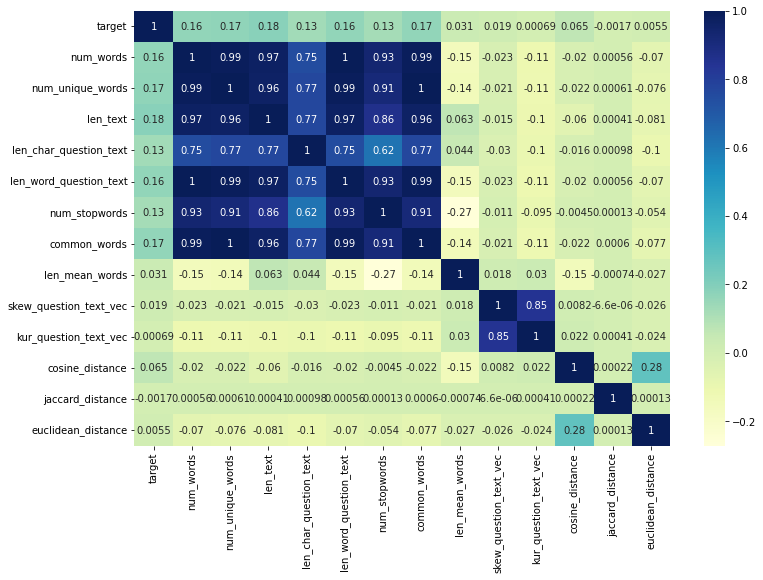

<Figure size 7200x720 with 0 Axes>

In [9]:
columns=[3,6,10,11,13,14,15]
drop_col=[0,1,2,4,5,7,8,9,12]
# newData=data.drop(data.columns[drop_col],axis=1,inplace=True)
# data.drop([item for item in len(data) if item not in columns], axis=1)
data.head()
showHeatmap(data)


# Split to X and Y

In [10]:
def getXY(data,numOfSamples):
    # get data
    y = data.iloc[:numOfSamples,2].values
    #     columns = [3,4,5,6,7,8,9]
    X = data.iloc[:numOfSamples,columns].values
    X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.20, random_state=42)
    return X_train,X_test,y_train,y_test

In [11]:
X_train,X_test,y_train,y_test=getXY(data,1306112)

# Logistic Regression

In [12]:
def getLogResPred():
    logres = linear_model.LogisticRegression(C=0.1, solver='sag', max_iter=1000000000,n_jobs=num_cores-1)
    logres.fit(X_train,y_train)
    lr_pred = logres.predict(X_test)
    print("Training accuracy: %0.5f"%logres.score(X_train,y_train))
    print("Testing accuracy: %0.5f"%logres.score(X_test,y_test))
    
    lr_prob=logres.predict_proba(X_test)
    lr_prob=lr_prob[:,1]
    
    F1_score = f1_score(y_test, lr_pred, average='weighted')
    Precision = precision_score(y_test, lr_pred, average='weighted',zero_division=1)
    recall = recall_score(y_test, lr_pred, average='weighted', zero_division=1)

    print("F1 score: %0.5f" % F1_score)
    print('Precision: %.5f' % Precision)
    print('Recall: %.5f' % recall)
    
    ax = plt.gca()
    rfc_disp = RocCurveDisplay.from_estimator(logres, X_test, y_test, ax=ax, alpha=0.8)
    plt.savefig('LogresROCAUC.png')
    plt.show()
    
    display = PrecisionRecallDisplay.from_estimator(logres, X_test, y_test, name="Logistic regression")
    _ = display.ax_.set_title("2-class Precision-Recall curve")


    
    return lr_pred, lr_prob

Training accuracy: 0.93793
Testing accuracy: 0.93834
F1 score: 0.90878
Precision: 0.90380
Recall: 0.93834


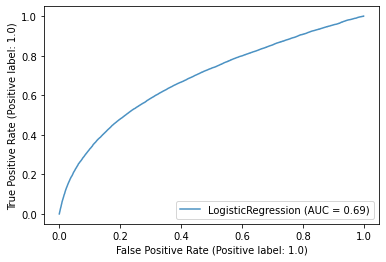

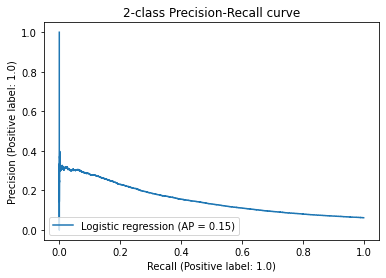

In [13]:
lr_pred,lr_prob=getLogResPred()

# LDA

In [14]:
def getLDAPred():
    lda = LinearDiscriminantAnalysis(solver='lsqr')
    
    #tuning LDA hyperparamaeters
    grid = dict()
    
    results = lda.fit(X_train, y_train)
    yhat = lda.predict(X_test)
    lda_prob=lda.predict_proba(X_test)
    print("Training accuracy: %0.5f"%lda.score(X_train,y_train))
    print("Testing accuracy: %0.5f"%lda.score(X_test,yhat))
    F1_score = f1_score(y_test, yhat, average='weighted')
    Precision = precision_score(y_test, yhat, average='weighted',zero_division=1)
    recall = recall_score(y_test, yhat, average='weighted',zero_division=1)

    print('Precision: %.3f' % Precision)
    print('Recall: %.3f' % recall)
    print("F1 score: %0.3f" % F1_score)
    
    ax = plt.gca()
    rfc_disp = RocCurveDisplay.from_estimator(lda, X_test, y_test, ax=ax, alpha=0.8)
    plt.savefig('LdaROCAUC.png')
    plt.show()
    
    display = PrecisionRecallDisplay.from_estimator(lda, X_test, y_test, name="LDA")
    _ = display.ax_.set_title("2-class Precision-Recall curve")
    
    return yhat, lda_prob

Training accuracy: 0.93439
Testing accuracy: 1.00000
Precision: 0.899
Recall: 0.935
F1 score: 0.911


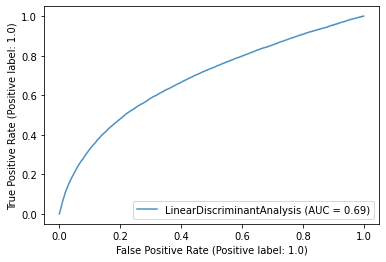

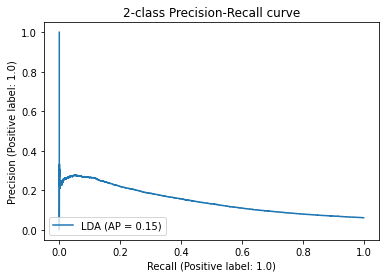

In [15]:
lda_pred,lda_prob=getLDAPred()

# Random Forests

In [16]:
def getRandomForest():
    RF_model = RandomForestClassifier(n_estimators=10, random_state=42)
    RF_model.fit(X_train,y_train)
    RF_preds = RF_model.predict(X_test)
    RF_prob=RF_model.predict_proba(X_test)
    print("Training accuracy: %0.3f"%RF_model.score(X_train,y_train))
    print("Testing accuracy: %0.3f"%RF_model.score(X_test,y_test))

    F1_score1 = f1_score(y_test, RF_preds, average='weighted')
    Precision1 = precision_score(y_test, RF_preds, average='weighted',zero_division=1)
    recall1 = recall_score(y_test, RF_preds, average='weighted',zero_division=1)

    print('Precision: %.3f' % Precision1)
    print('Recall: %.3f' % recall1)
    print("F1 score: %0.3f" % F1_score1)
    
    ax = plt.gca()
    rfc_disp = RocCurveDisplay.from_estimator(RF_model, X_test, y_test, ax=ax, alpha=0.8)
    plt.savefig('RandForestROCAUC.png')
    plt.show()
    
    display = PrecisionRecallDisplay.from_estimator(RF_model, X_test, y_test, name="Random Forests")
    _ = display.ax_.set_title("2-class Precision-Recall curve")
    
    return RF_preds,RF_prob

Training accuracy: 0.988
Testing accuracy: 0.937
Precision: 0.904
Recall: 0.937
F1 score: 0.911


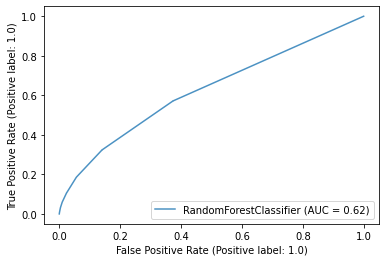

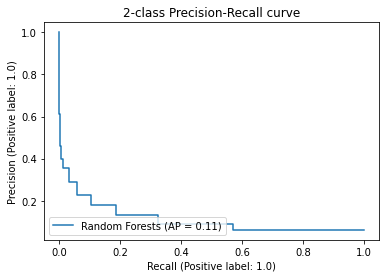

In [17]:
rf_pred,rf_prob=getRandomForest()

# SVM (for smaller sample)

In [18]:
def getSVMPred():
    svc_model=SVC(C=0.2,kernel='linear',gamma=1,probability=True)
    svc_model.fit(X_train,y_train)
    svm_pred=svc_model.predict(X_test)
    
    svm_prob=svc_model.predict_proba(X_test)
#     svm_prob=svm_prob[:,1]
    
    print("Training accuracy: %0.3f"%svc_model.score(X_train,y_train))
    print("Testing accuracy: %0.3f"%svc_model.score(X_test,y_test))

    F1_score = f1_score(y_test, svm_pred, average='weighted')
    Precision = precision_score(y_test, svm_pred, average='weighted',zero_division=1)
    recall = recall_score(y_test, svm_pred, average='weighted',zero_division=1)

    print('Precision: %.3f' % Precision)
    print('Recall: %.3f' % recall)
    print("F1 score: %0.3f" % F1_score)
    
    ax = plt.gca()
    rfc_disp = RocCurveDisplay.from_estimator(svc_model, X_test, y_test, ax=ax, alpha=0.8)
    plt.savefig('SvmROCAUC.png')
    plt.show()
    
    display = PrecisionRecallDisplay.from_estimator(svc_model, X_test, y_test, name="SVM")
    _ = display.ax_.set_title("2-class Precision-Recall curve")
    
    return svm_pred,svm_prob

Training accuracy: 0.944
Testing accuracy: 0.954
Precision: 0.956
Recall: 0.954
F1 score: 0.931


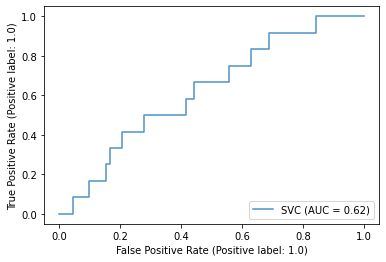

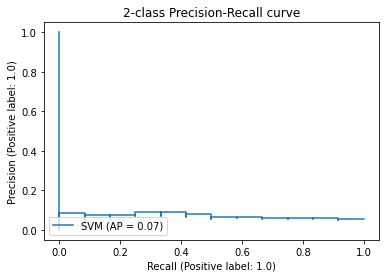

In [19]:
# (This is taking too much time)
X_train,X_test,y_train,y_test=getXY(data,1300)
svm_pred,svm_prob=getSVMPred()

# Confusion matrix

In [20]:
def plot_cm(labels, predictions, p=0.5):
    cm = metrics.confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [ ]:
plot_cm(y_test,lr_pred)

In [ ]:
plot_cm(y_test,lda_pred)

In [ ]:
plot_cm(y_test,rf_pred)

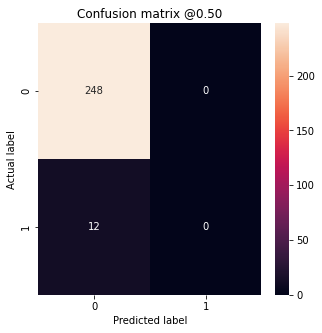

In [22]:
plot_cm(y_test,svm_pred)

# Data Rebalancing and refitting Logistic Regression

In [23]:
data=pd.read_csv("embed+tfidf.csv")
data.shape

(1681928, 16)

## Discarding Majority

In [24]:
def discardMajority(data):
    count0, count1 = data["target"].value_counts()
    # print(count0)
#     df_class_0=data[data where data['target']==0]
    df_class_0 = data[(data["target"] ==0.0)]
    df_class_1 = data[(data["target"] ==1.0)]
#     df_class_1=data[data['target']==1]
    
    df_class_0_under = df_class_0.sample(count1)
    df_test_under=pd.concat([df_class_0_under,df_class_1],axis=0)
    print(df_test_under.target.value_counts())
    return df_test_under

In [25]:
disc_data=pd.read_csv("embed+tfidf.csv")
disc_data=discardMajority(data)
disc_data.shape
disc_data.tail()

0.0    80810
1.0    80810
Name: target, dtype: int64


qid  \
1306093  fffeba722d9b371bd1b9   
1306094  fffee269360dd0d3947a   
1306099  ffff0e4ea1bb6e16feec   
1306103  ffff3f0a2449ffe4b9ff   
1306112  ffffa5b0fa76431c063f   

                                             question_text  target  num_words  \
1306093  How is it to have intimate relation with your ...     1.0         10   
1306094  Why is it when singers have lyrics about voice...     1.0         35   
1306099                  Do pakis smell of curry and shit?     1.0          7   
1306103  Isn't Trump right after all? Why should the US...     1.0         35   
1306112                Are you ashamed of being an Indian?     1.0          7   

         num_unique_words  len_text  len_char_question_text  \
1306093                10        53                      18   
1306094                33       205                      24   
1306099                 7        33                      20   
1306103                34       213                      37   
1306112                 7        35                      18   

         len_word_question_text  num_stopwords  common_words  len_mean_words  \
1306093                      10              7            10        4.400000   
1306094                      35             17            32        4.885714   
1306099                       7              3             7        3.857143   
1306103                      35             15            34        5.114286   
1306112                       7              5             7        4.142857   

         skew_question_text_vec  kur_question_text_vec  cosine_distance  \
1306093                0.665245               4.527226         1.012156   
1306094                1.350156               8.031527         0.933212   
1306099                0.657853               2.250692         1.057209   
1306103                0.625206               3.767523         1.035427   
1306112                4.169949              26.658543         1.128056   

         jaccard_distance  euclidean_distance  
1306093               1.0            1.422783  
1306094               1.0            1.366171  
1306099               1.0            1.454104  
1306103               1.0            1.439046  
1306112               1.0            1.502036

In [26]:
data.shape

(1681928, 16)

In [27]:
disc_data.shape

(161620, 16)

In [ ]:
X_train,X_test,y_train,y_test=getXY(disc_data,75000)
bal_pred,bal_prob=getLogResPred()

### Oversampling

In [32]:
def oversampling(train):
    count0, count1 = train["target"].value_counts()
    # print(count0)
    df_class_0=train[train['target']==0.0]
    df_class_1=train[train['target']==1.0]
    
    df_class_1_over = df_class_1.sample(count0, replace=True)
    df_test_over=pd.concat([df_class_0,df_class_1_over],axis=0)
    print(df_test_over.target.value_counts())
    return df_test_over

In [33]:
data=pd.read_csv("embed+tfidf.csv")
data=oversampling(data)
data.shape
data.tail()

0.0    1225312
1.0    1225312
Name: target, dtype: int64


qid  \
366651  47de5d7d4cbb8fcf4428   
903087  b0f61a2373be3a71507b   
625714  7a88560e9ac53c458cb8   
181212  236ac09c04ae37f3dffd   
751289  9331f53ad583b8c714d2   

                                            question_text  target  num_words  \
366651  How can we save our community from Thunderclap...     1.0         14   
903087  Why Trump supports Israel after they betrayed ...     1.0         20   
625714  Why did Hamas never use the attack tunnels to ...     1.0         11   
181212  Macron says that the USA needs to make Syria i...     1.0         18   
751289  Since Tamils are still being oppressed, Is it ...     1.0         14   

        num_unique_words  len_text  len_char_question_text  \
366651                14        82                      24   
903087                19       128                      26   
625714                11        63                      21   
181212                18        90                      25   
751289                14        78                      25   

        len_word_question_text  num_stopwords  common_words  len_mean_words  \
366651                      14              9            14        4.928571   
903087                      20              8            18        5.450000   
625714                      11              4            11        4.818182   
181212                      18              8            18        4.055556   
751289                      14              8            14        4.642857   

        skew_question_text_vec  kur_question_text_vec  cosine_distance  \
366651               -0.013280               2.473565         0.986275   
903087                1.584920              12.592281         1.052382   
625714                4.707721              32.059175         0.976532   
181212                0.152124               7.810014         0.957067   
751289                4.279920              31.287549         1.029414   

        jaccard_distance  euclidean_distance  
366651               1.0            1.404475  
903087               1.0            1.450780  
625714               1.0            1.397521  
181212               1.0            1.383523  
751289               1.0            1.434862

In [34]:
y = data.iloc[:,2].values
    #     columns = [3,4,5,6,7,8,9]
X = data.iloc[:,columns].values
X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.20, random_state=42)

Training accuracy: 0.64407
Testing accuracy: 0.64380
F1 score: 0.64277
Precision: 0.64545
Recall: 0.64380


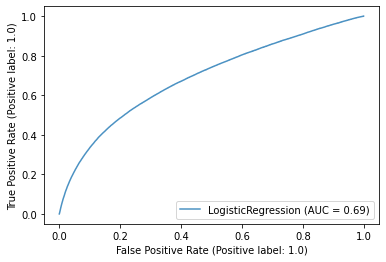

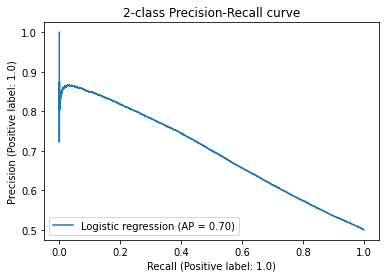

In [35]:
over_lr_pred,over_lr_prob=getLogResPred()

In [37]:
### Plays sound when notebook execution completed

In [36]:
import IPython
IPython.display.Audio("my_audio_file.mp3")